# Summary of Findings

* exclude tracks based on non-musical genres:
	* e.g., 'sleep', 'ringtone', etc.
* exclude tracks based on domain knowledge:
	* songs <1min or >10min are extreme outliers (less likely to be songs than misc audio)
        * duration_ms < 60_000
        * duration_ms > 600_000
* exclude select extrema for audio features based on inspection:
    * 99% range (from 0.5% to 99.5% was used)
    * some outlier regions appear to contain songs, including hit songs
    * some outlier regions include mostly non-music tracks
        * valence == 0
        * speechiness > 0.947000
        * tempo == 0
        * loudness < -34.668999
        * danceability < 0.064400
* other outlier exclusion methods didn't work effectively
    * IQR and Z values excluded very little
    * LocalOutlierFactor() from sklearn not effective by default and very slow

# Imports

In [1]:
import spotipy
import re

# math and dataframes
import pandas as pd
import numpy as np
from scipy.stats import zscore

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
# all songs with audio features (combined from 3 sources)
df_10M = pd.read_pickle('df_10M.pickle')

# all Billboard 100 lists, audio features included where possible
df_B100 = pd.read_pickle('df_B100.pickle')

# all unique songs from the Billboard 100 lists, audio features included where possible
df_B100_songs = pd.read_pickle('df_B100_songs.pickle')

In [3]:
# confirm import worked (B100 songs are all in df_10M, no duplicates)
id_B100 = set(df_B100_songs[~df_B100_songs.id.isnull()].id)
len(id_B100), df_10M[df_10M.id.isin(id_B100)].shape[0]
# GOOD!

(21274, 21274)

# OUTLIERS

### METHOD 1:  IQR
(didn't work)

In [4]:
df_B100_range = df_B100_songs.describe().T[['min', 'max']]
df_outliers = df_10M.describe()['min':'max'].T

In [5]:
df_B100_range

,min,max
acousticness,0.000,0.996
danceability,0.000,0.988
duration_ms,12507.000,2902827.000
energy,0.000,0.999
instrumentalness,0.000,0.996
key,0.000,11.000
liveness,0.000,1.000
loudness,-60.000,2.291
mode,0.000,1.000
speechiness,0.000,0.949


In [6]:
df_outliers

,min,25%,50%,75%,max
acousticness,0.000,0.034,0.337,0.817,0.996
danceability,0.000,0.396,0.545,0.676,1.000
duration_ms,1000.000,169507.000,216851.000,275053.000,6072187.000
energy,0.000,0.311,0.567,0.789,1.000
instrumentalness,0.000,0.000,0.002,0.647,1.000
key,0.000,2.000,5.000,8.000,11.000
liveness,0.000,0.096,0.129,0.262,1.000
loudness,-60.000,-13.674,-9.195,-6.397,7.234
mode,0.000,0.000,1.000,1.000,1.000
speechiness,0.000,0.036,0.047,0.082,0.974


In [7]:
df_outliers['IQR'] = df_outliers['75%'] - df_outliers['25%']
df_outliers['out_low'] = df_outliers['25%'] - 1.5 * df_outliers['IQR']
df_outliers['out_high'] = df_outliers['75%'] + 1.5 * df_outliers['IQR']
df_outliers

,min,25%,50%,75%,max,IQR,out_low,out_high
acousticness,0.000,0.034,0.337,0.817,0.996,0.783,-1.142,1.992
danceability,0.000,0.396,0.545,0.676,1.000,0.280,-0.024,1.096
duration_ms,1000.000,169507.000,216851.000,275053.000,6072187.000,105546.000,11188.000,433372.000
energy,0.000,0.311,0.567,0.789,1.000,0.478,-0.406,1.506
instrumentalness,0.000,0.000,0.002,0.647,1.000,0.647,-0.970,1.617
key,0.000,2.000,5.000,8.000,11.000,6.000,-7.000,17.000
liveness,0.000,0.096,0.129,0.262,1.000,0.166,-0.152,0.510
loudness,-60.000,-13.674,-9.195,-6.397,7.234,7.277,-24.589,4.519
mode,0.000,0.000,1.000,1.000,1.000,1.000,-1.500,2.500
speechiness,0.000,0.036,0.047,0.082,0.974,0.047,-0.034,0.152


In [8]:
# this didn't exclude anything except liveliness > 0.51, speechiness > 0.152 and duration_ms
# let's check duration, to see if it's useful
df_outliers.loc['duration_ms', 'out_low'] / (60 * 1000), df_outliers.loc['duration_ms', 'out_high'] / (60 * 1000)

# 12 second songs, nope
# 7 minute songs, maybe

(0.18646666666666667, 7.2228666666666665)

### METHOD 2:  Z-scores
(didn't work)

#### ESTIMATE (not exactly correct unless Gaussian):
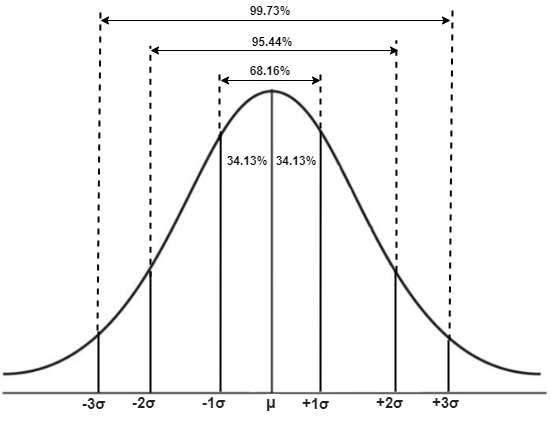

In [9]:
# helper function, check z scores
def check_z_score(z_exclude=3):
    z_scores = {1: 0.6816, 2: 0.9544, 3: 0.9973}
    z_exclude = z_exclude
    low_quartile = round((1 - z_scores[z_exclude]) / 2, 5)
    high_quartile = round(1 - (1 - z_scores[z_exclude]) / 2, 5)

    quartiles = [low_quartile, high_quartile]

    df_B100_range = df_B100_songs.describe().T
    df_10M_range = df_10M.describe(quartiles)['min':'max'].T

    output_df = pd.concat(
        [df_B100_range.rename({'min': 'B100_min', 'max': 'B100_max'}, axis=1), df_10M_range], 
        axis=1)
    
    output_df['low_error'] = output_df['B100_min'] - output_df[df_10M_range.columns[1]]
    output_df['high_error'] = output_df[df_10M_range.columns[3]] - output_df['B100_max']
    
    output_df.loc[['duration_ms', ]] = output_df.loc[['duration_ms', ]] / 60_000  # convert ms to minutes
    output_df = output_df.rename({'duration_ms': 'minutes'})
    
    return output_df[['B100_min', df_10M_range.columns[1], 'low_error', 'B100_max', df_10M_range.columns[3], 'high_error']]



In [10]:
# z-score > 3
z3 = check_z_score(3)

# z-score > 2
z2 = check_z_score(2)

In [11]:
z3

,B100_min,0.1%,low_error,B100_max,99.9%,high_error
acousticness,0.000,0.000,-0.000,0.996,0.996,0.000
danceability,0.000,0.000,0.000,0.988,0.950,-0.038
minutes,0.208,0.137,0.072,48.380,25.059,-23.321
energy,0.000,0.001,-0.001,0.999,0.999,0.000
instrumentalness,0.000,0.000,0.000,0.996,0.989,-0.007
key,0.000,0.000,0.000,11.000,11.000,0.000
liveness,0.000,0.000,0.000,1.000,0.981,-0.019
loudness,-60.000,-40.092,-19.908,2.291,-0.811,-3.102
mode,0.000,0.000,0.000,1.000,1.000,0.000
speechiness,0.000,0.000,0.000,0.949,0.960,0.011


In [12]:
z2

,B100_min,2.3%,low_error,B100_max,97.7%,high_error
acousticness,0.000,0.000,-0.000,0.996,0.993,-0.003
danceability,0.000,0.139,-0.139,0.988,0.859,-0.129
minutes,0.208,0.931,-0.723,48.380,8.884,-39.496
energy,0.000,0.027,-0.027,0.999,0.978,-0.021
instrumentalness,0.000,0.000,0.000,0.996,0.948,-0.048
key,0.000,0.000,0.000,11.000,11.000,0.000
liveness,0.000,0.048,-0.048,1.000,0.803,-0.197
loudness,-60.000,-27.790,-32.210,2.291,-3.046,-5.337
mode,0.000,0.000,0.000,1.000,1.000,0.000
speechiness,0.000,0.027,-0.027,0.949,0.508,-0.441


In [13]:
Z_errors = pd.concat([
    z3[[z3.columns[2], z3.columns[5]]].rename({z3.columns[2]: 'Z_error_low_3', z3.columns[5]: 'Z_error_high_3'}, axis=1), 
    z2[[z2.columns[2], z2.columns[5]]].rename({z2.columns[2]: 'Z_error_low_2', z2.columns[5]: 'Z_error_high_2'}, axis=1)], axis=1)
Z_errors

,Z_error_low_3,Z_error_high_3,Z_error_low_2,Z_error_high_2
acousticness,-0.000,0.000,-0.000,-0.003
danceability,0.000,-0.038,-0.139,-0.129
minutes,0.072,-23.321,-0.723,-39.496
energy,-0.001,0.000,-0.027,-0.021
instrumentalness,0.000,-0.007,0.000,-0.048
key,0.000,0.000,0.000,0.000
liveness,0.000,-0.019,-0.048,-0.197
loudness,-19.908,-3.102,-32.210,-5.337
mode,0.000,0.000,0.000,0.000
speechiness,0.000,0.011,-0.027,-0.441


In [14]:
df_sqerr = pd.DataFrame()
df_sqerr['Z3'] = Z_errors['Z_error_low_3'] * Z_errors['Z_error_low_3'] + Z_errors['Z_error_high_3'] * Z_errors['Z_error_high_3']
df_sqerr['Z2'] = Z_errors['Z_error_low_2'] * Z_errors['Z_error_low_2'] + Z_errors['Z_error_high_2'] * Z_errors['Z_error_high_2']
df_sqerr['Z3_is_best'] = df_sqerr['Z2'] > df_sqerr['Z3']
df_sqerr

# therefore Zscore of 3 is best for outlier removal

,Z3,Z2,Z3_is_best
acousticness,0.000,0.000,True
danceability,0.001,0.036,True
minutes,543.894,1560.456,True
energy,0.000,0.001,True
instrumentalness,0.000,0.002,True
key,0.000,0.000,False
liveness,0.000,0.041,True
loudness,405.951,1065.968,True
mode,0.000,0.000,False
speechiness,0.000,0.195,True


In [15]:
z3[[z3.columns[1], z3.columns[4]]]

,0.1%,99.9%
acousticness,0.000,0.996
danceability,0.000,0.950
minutes,0.137,25.059
energy,0.001,0.999
instrumentalness,0.000,0.989
key,0.000,11.000
liveness,0.000,0.981
loudness,-40.092,-0.811
mode,0.000,1.000
speechiness,0.000,0.960


In [16]:
df_B100_songs.describe().T[['min', 'max']]

,min,max
acousticness,0.000,0.996
danceability,0.000,0.988
duration_ms,12507.000,2902827.000
energy,0.000,0.999
instrumentalness,0.000,0.996
key,0.000,11.000
liveness,0.000,1.000
loudness,-60.000,2.291
mode,0.000,1.000
speechiness,0.000,0.949


In [17]:
# longest and shortest songs on B100
df_B100_songs.describe().T[['min', 'max']].rename({'duration_ms': 'minutes'}, axis=1).loc[['duration_ms']] / 60_000

,min,max
duration_ms,0.208,48.380


In [18]:
# yep, actually 48 minutes, a live version, correct song, but probalby an outlier
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.max()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
18120,0mEyKJpqUP6lnNvySIUhsF,Electric Barbarella,Duran Duran,rock,2017-05-03,0.004,0.364,2902827,0.853,0.001,2,0.684,-9.295,1,0.088,127.055,4,0.180


In [20]:
# yep, not the normal version of the song
# also, API doesn't use '- callout' in the name so can get a false positive
# outlier
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.min()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
15906,4EIMnC6rzLlYvvIOq1tHqS,In Love With A Girl,Gavin DeGraw,pop rock,2007-10-25,0.058,0.000,12507,0.798,0.000,3,0.235,-4.763,1,0.000,0.000,0,0.000


##### check actual zscores for duration

In [48]:
# not an outlier, (no songs are short enough to be considered outliers)
zscore(df_B100_songs.duration_ms.to_list())[15906]

-2.9370678974825735

### METHOD 3: Percentile
works pretty good, but may exclude some songs

In [59]:
# intervals:  99.9%, 99%, and 95%
percentile = [0.0005, 0.005, 0.025, 0.975, 0.995, 0.9995]
TEMP = df_B100_songs.copy()
TEMP['minutes'] = TEMP['duration_ms'].apply(lambda x: x / 60_000)
TEMP.drop('duration_ms', axis=1).describe(percentile)['min':'max'].T

,min,0.05%,0.5%,2.5%,50%,97.5%,99.5%,99.95%,max
acousticness,0.000,0.000,0.000,0.001,0.204,0.898,0.961,0.991,0.996
danceability,0.000,0.113,0.192,0.273,0.605,0.881,0.935,0.968,0.988
energy,0.000,0.024,0.107,0.204,0.630,0.941,0.975,0.994,0.999
instrumentalness,0.000,0.000,0.000,0.000,0.000,0.656,0.905,0.961,0.996
key,0.000,0.000,0.000,0.000,5.000,11.000,11.000,11.000,11.000
liveness,0.000,0.017,0.029,0.043,0.134,0.784,0.970,0.991,1.000
loudness,-60.000,-27.614,-20.190,-16.650,-8.369,-3.232,-2.278,-0.727,2.291
mode,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000
speechiness,0.000,0.022,0.024,0.026,0.042,0.350,0.485,0.900,0.949
tempo,0.000,50.764,65.949,75.072,119.230,182.752,202.655,209.992,241.009


In [62]:
# 99% seems like the right choice for duration (based on my expertise)
TEMP.drop('duration_ms', axis=1).describe(percentile)['min':'max'][['minutes']]

,minutes
min,0.208
0.05%,0.562
0.5%,1.738
2.5%,2.067
50%,3.550
97.5%,6.321
99.5%,8.372
99.95%,11.883
max,48.380


In [77]:
df_outlier_limits_99 = (
    df_B100_songs
    .describe([0.005, 0.995])['0.5%':'99.5%':2].T
    .drop(['key', 'mode', 'time_signature'])
)
df_outlier_limits_99

,0.5%,99.5%
acousticness,0.000,0.961
danceability,0.192,0.935
duration_ms,104272.530,502313.490
energy,0.107,0.975
instrumentalness,0.000,0.905
liveness,0.029,0.970
loudness,-20.190,-2.278
speechiness,0.024,0.485
tempo,65.949,202.655
valence,0.071,0.973


In [79]:
df_outlier_limits_99.columns = ['lower_limit', 'upper_limit']
df_outlier_limits_99

,lower_limit,upper_limit
acousticness,0.000,0.961
danceability,0.192,0.935
duration_ms,104272.530,502313.490
energy,0.107,0.975
instrumentalness,0.000,0.905
liveness,0.029,0.970
loudness,-20.190,-2.278
speechiness,0.024,0.485
tempo,65.949,202.655
valence,0.071,0.973


In [80]:
# these could be good
df_outlier_limits_99.to_pickle('df_outlier_limits_99.pickle')

In [81]:
# let's compart to df_10M
# there are WAY more extreme songs in df_10M
(
    df_10M
    .describe([0.005, 0.995])['0.5%':'99.5%':2].T
    .drop(['key', 'mode', 'time_signature'])
)

,0.5%,99.5%
acousticness,0.000,0.995
danceability,0.065,0.918
duration_ms,22107.000,868733.000
energy,0.005,0.995
instrumentalness,0.000,0.975
liveness,0.030,0.962
loudness,-34.602,-1.826
speechiness,0.024,0.947
tempo,48.654,201.512
valence,0.000,0.973


In [83]:
# maybe 95% would be better
(
    df_10M
    .describe([0.025, 0.975])['2.5%':'97.5%':2].T
    .drop(['key', 'mode', 'time_signature'])
)

,2.5%,97.5%
acousticness,0.000,0.992
danceability,0.144,0.855
duration_ms,59000.000,520160.000
energy,0.030,0.977
instrumentalness,0.000,0.946
liveness,0.049,0.780
loudness,-27.361,-3.129
speechiness,0.027,0.479
tempo,68.292,181.613
valence,0.036,0.962


In [ ]:
# not sure how to deal with information leakage
# if outlier limits are determined from B100, they are used to predict themselves
# may need a crossvalidate pipeline with outlier removal as part of the pipe

In [84]:
# but is 95% too much for B100?
(
    df_B100_songs
    .describe([0.025, 0.975])['2.5%':'97.5%':2].T
    .drop(['key', 'mode', 'time_signature'])
)

# do they need to be processed the same 
# (I think so, but there are a lot of non-music or obscure things on Spotify)

,2.5%,97.5%
acousticness,0.001,0.898
danceability,0.273,0.881
duration_ms,124000.000,379231.550
energy,0.204,0.941
instrumentalness,0.000,0.656
liveness,0.043,0.784
loudness,-16.650,-3.232
speechiness,0.026,0.350
tempo,75.072,182.752
valence,0.141,0.964


### METHOD 4: Domain Knowledge
good: include this
* source = me:
    * songs are at least 1 minute long and less than 10 minutes

In [52]:
# 82 song length outliers (0.32%)
too_short, too_long = sum(df_B100_songs.duration_ms < 60_000), sum(df_B100_songs.duration_ms > 600_000)
too_short, too_long, too_short + too_long, (too_short + too_long) / df_B100_songs.duration_ms.count()

(35, 47, 82, 0.003214803779354687)

In [ ]:
# seems OK, and close to 99% interval

### Notes on Importing and Avoiding Outliers / Errors:
* maybe a better idea for how to merge B100 and 10M
    * exact matches only
    * API
    * then approx matches for missing
    
* ALT (slow version)
    * API first
    * then match exact, then missing
    
* Neither will be 100%, probably best to just exclude outliers for predictions
* Both of the extreme outlier songs examined were mostly correct, but a sub-optimal version
    * audio feature data would likely be mostly correct for these songs

* Other than duration_ms, not sure if other audio features should be considered for outliers

### METHOD 5: sklearn.neighbors.LocalOutlierFactor()
might be good, but would take weeks to tune hyperparameters

In [191]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import LocalOutlierFactor

In [192]:
X = df_10M[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness',
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]  # exclude key, time_signature, mode
X.index = df_10M['id']

In [197]:
# do less rows to check speed
X_1k = X.head(1_000)
X_10k = X.head(10_000)
X_100k = X.head(100_000)

In [198]:
%%time

qt = QuantileTransformer()
X_qt = qt.fit_transform(X_1k)

clf_out = LocalOutlierFactor()
X_out = clf_out.fit_predict(X_qt)

Wall time: 38.9 ms


In [194]:
%%time

qt = QuantileTransformer()
X_qt = qt.fit_transform(X_10k)

clf_out = LocalOutlierFactor()
X_out = clf_out.fit_predict(X_qt)

Wall time: 870 ms


In [195]:
%%time

qt = QuantileTransformer()
X_qt = qt.fit_transform(X_100k)

clf_out = LocalOutlierFactor()
X_out = clf_out.fit_predict(X_qt)

Wall time: 33.1 s


# ~5 hours per scenario
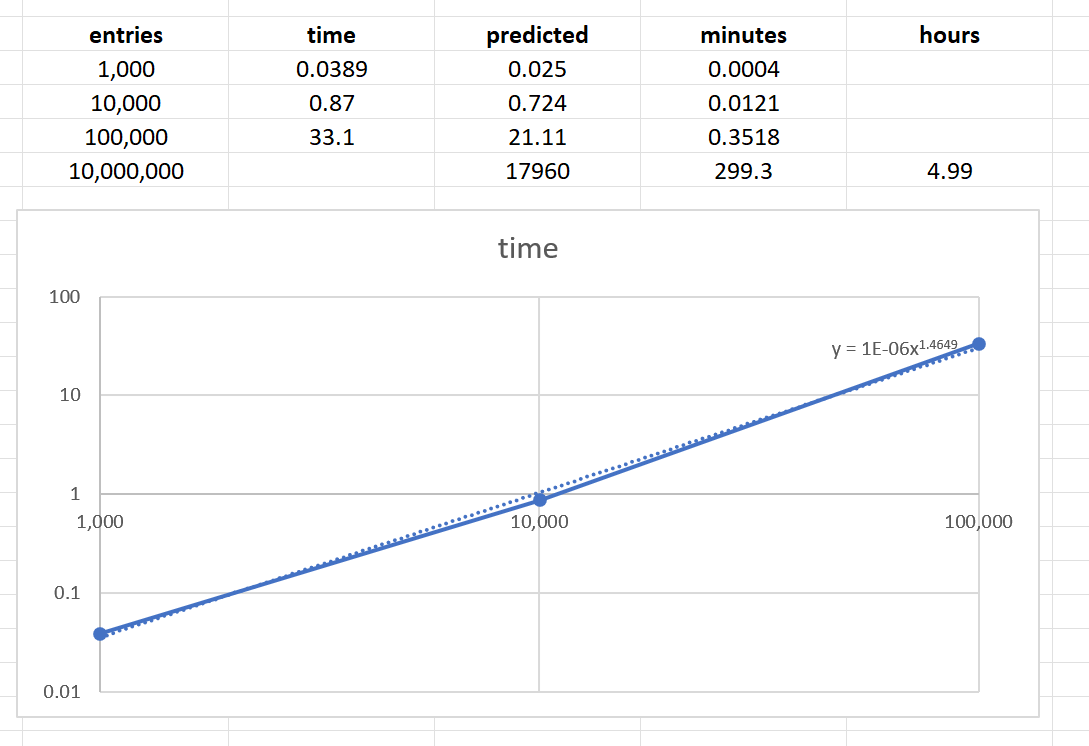

In [18]:
# check results - these look like outliers for sure
df_10M[df_10M.id.isin(set(X[X_out == -1].index))]

# the only songs on here are 
"""
Jemand Lief Amok Auf Der Mayday	...But Alive  # very intense punk music, poor audio quality
Who Knows Where the Time Goes?	10,000 Maniacs  # sounds like a normal song, but has 2 min dead air at the end
"""

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
1708,1FsVUf5Uzhy7yAx0D7Q3cm,Nature Trails,#Sleep,sleep,2020-02-10,0.929,0.072,150000,0.484,0.918,4,0.695,-30.229,0,0.090,79.991,5,0.021,False
2325,1RqvQPm5ynqb8Py10SgIM3,Intermission with the Gods (Interlude),$tar$eed,NaN,NaT,0.972,0.300,170344,0.659,0.903,1,0.789,-7.970,0,0.051,76.258,3,0.060,False
4865,7xUthB9jFcA5MXMRWPqMdN,Jemand Lief Amok Auf Der Mayday,...But Alive,german punk,1998-05-01,0.000,0.409,251093,0.001,0.078,7,0.143,-4.675,1,0.087,113.391,4,0.903,False
4959,5AGk0U6FYY39FZcaCCnUo2,Thank You For Your Time,...music video?,tucson indie,2004-01-01,0.991,0.000,7000,0.353,0.000,0,0.000,-21.168,1,0.000,0.000,0,0.000,False
5105,3yY2ExH2Awk253MneKmOr8,.,.bipolar.,<NA>,2012-11-02,0.000,0.000,182000,0.000,0.000,0,0.000,-60.000,0,0.000,0.000,0,0.000,False
6013,1sTVvE61TBFJqifntliGWa,Pedo (おなら Furz Fart Pet),1,sound effects,2012-02-20,0.000,0.000,5319,0.439,0.002,2,0.000,-20.796,1,0.000,0.000,0,0.000,False
6014,6xYDFftQhuMG1B5sT3g9si,Risas De Mujer (Frauen Lachen),1,sound effects,2012-02-20,0.859,0.000,12125,0.924,0.025,3,0.198,-9.736,0,0.000,0.000,0,0.000,False
6015,4XrHRpovOtz1fJpBNHu4AY,Gran Pedo (おなら Furz Fart Pet),1,sound effects,2012-02-20,0.000,0.000,3722,0.060,0.000,1,0.000,-14.129,1,0.000,0.000,0,0.000,False
6019,3tCUJaelXa5qtWWbyU39eb,Pedo 2 (おなら Furz Fart Pet),1,sound effects,2012-02-20,0.867,0.000,3650,0.559,1.000,5,0.000,-20.439,1,0.000,0.000,0,0.000,False
6021,0Wwtqba02lFC7YC2A23gX4,Pedo Largo (おなら Furz Fart Pet),1,sound effects,2012-02-20,0.000,0.000,4785,0.015,0.000,4,0.000,-19.867,1,0.000,0.000,0,0.000,False


In [25]:
# are these all songs?
df_10M[df_10M.id.isin(set(X[X_out == 1].index))].sample(20)
# no. there are 'football' and 'ringtone' genres included, some very short songs

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
7816,1wSDy4kNfqyJixNgDrWsEL,071 Eloping With a Millionaire,100 Instrumentals,beats,2010-09-25,0.003,0.727,244253,0.566,0.926,10,0.135,-11.950,0,0.165,93.997,4,0.137,False
2651,3OPynmNaSuaOjPTdkmQW00,Okie Dokie Stomp (1954),''Gatemouth'' Brown,NaN,NaT,0.642,0.480,153267,0.743,0.001,10,0.313,-5.152,0,0.042,181.771,4,0.843,False
4507,1YlhmgGDDah1cfadrcafWI,Wait a Minute,-M-,chanson,2016-01-22,0.045,0.767,192679,0.603,0.000,9,0.056,-4.550,0,0.203,150.168,4,0.966,False
6586,2Fl6pn7l998h2mW2wJJkWH,Meine Stadt,1.FCN Fans Fangesänge,football,2016-03-23,0.739,0.556,22700,0.902,0.909,5,0.182,-7.560,1,0.106,82.285,4,0.179,False
2546,1S4MM1ukLm3ourrBJGHniC,[whispers Indistinctly],$uicideboy$,underground hip hop,2020-02-14,0.182,0.899,164624,0.716,0.000,11,0.191,-6.592,0,0.347,140.038,4,0.656,False
5982,71LXYDPiZ7OLTSPdFFGn17,Dotdotdotsix,0N4B,african experimental,2018-11-28,0.011,0.774,335018,0.402,0.387,6,0.047,-14.677,0,0.202,129.965,5,0.400,False
6329,2oEltWv1p5YgETvzjtgmCm,Graveyard Paradise,1-2-6,norwegian prog,1968-06-18,0.148,0.576,177072,0.527,0.000,5,0.169,-8.345,1,0.030,100.482,3,0.551,False
6322,0ATGklmLJOBcBqEhEb1Bgg,Who's Been Sleeping in My Bed,1-2-6,norwegian prog,1968-06-18,0.003,0.693,125907,0.763,0.000,3,0.032,-8.741,1,0.044,108.882,4,0.518,False
4519,34jpGj9jQKWi2oU9vL9wae,Close to Me,-M-,chanson,1999-10-05,0.010,0.665,239973,0.831,0.084,10,0.047,-7.987,1,0.133,185.689,4,0.944,False
1835,73KwtRxljSDxlLvSByXkva,Top,$Ha Hef,NaN,NaT,0.219,0.702,204356,0.947,0.000,0,0.108,-5.393,1,0.406,83.990,4,0.386,False


##### not the best method:
* may need multiple hours to calculate the best hyperparameters
* no way to quantify how good these results are
* NOTE: should exclude some genres entirely (examples: 'ringtone', 'football', 'sound effects', 'sleep')

In [ ]:
# def print_outlier_results():
#     pass


# n_quantiles = [100, 1000, 10000]
# n_neighbors = [1, 2, 4, 8, 20, 50, 100]

# for i in n_quantiles:
#     qt = QuantileTransformer(n_quantiles=i)
#     X_qt = qt.fit_transform(X)

#     for j in n_neighbors:    
#         clf_out = LocalOutlierFactor(n_neighbors=j)
#         clf_out.fit_predict(X_qt)
        
#         print_outlier_results()

### METHOD 6: Genres to Exclude
##### SUCCESS, include this method

In [7]:
set_genre = set(df_10M.genre.unique())

In [97]:
# check some genres based on outlier song length
song_length = 2_400_000
df_10M[df_10M.duration_ms > song_length].sample(10)[['song', 'artist', 'duration_ms', 'genre']]

,song,artist,duration_ms,genre
454956,Composition 340,Ann Rhodes,2789347,<NA>
6060163,Nukleuz Hard Dance Classics 2011 - DJ Mix 1,Nukleuz DJs,3878972,NaN
825676,Late Night Tales: Belle and Sebastian - Contin...,Belle & Sebastian,4738853,alternative rock
2699131,Awel Hamsa - Live,Farid al-Atrash,3323797,NaN
8814816,Alf Leila We Leila,Umm Kulthum,2497280,classic arab pop
2554248,Psychologically Ultimate Seashore,Environments,3603400,bulgarian experimental
6594774,Digital Drugs 3: Shape The Machine DJ Mix (fea...,Psychedelic Mushrooms Infected With Hallucinogens,3431352,NaN
2888005,Continuous mix,Freaks,4658000,NaN
3547124,Hard Kryptic Records Yearmix 2018 - Continuous...,How Hard,2818399,dark hardcore
5650095,"Imagine the World, vol 1 - Mixed by Misja Hels...",Misja Helsloot,4648952,uplifting trance


In [100]:
# sets that aren't music
# by inspection using songs less than 1min or more than 10min (+ more extreme)
genres_to_exclude = set([
    'sleep', 'football', 'halloween', 'birthday', 'lullaby', 'ringtone', 'fan chant',
    'sound effects', 'spoken word', 'bible', 'prank', 'wrestling', 'language', 'oratory',
    'erotica', 'tone', 'vintage radio show', 'sound', 'quran', 'islamic recitation',
    'reading', 'asmr', 'mindfulness', 'meditation', 'guided meditation', 'workout product',
    'theme', 'environmental', 'motivation'    
])

In [114]:
# inspect some genres -  this looks like it's good
df_10M[df_10M.genre == 'theme'].sample(10)[['song', 'artist', 'duration_ms', 'genre']]

,song,artist,duration_ms,genre
6171773,Andy Reynold's Reel,Orlando Pops Orchestra,82587,theme
5743792,Once Upon a Time (Theme),Mount Royal Orchestra,86831,theme
1343728,Magilla Gorilla,Cartoon Theme Ensemble,68667,theme
1893187,"Theme (From ""Dream On"")",Daniel Caine Orchestra,178880,theme
7861388,Let's Make a Deal,TV Tunesters,90022,theme
5313382,"Tubular Bells (From ""The Exorcist"")",Mark Ayres,210387,theme
1618937,Spiderman & his amazing friends,Coded Channel,63190,theme
1343683,Heigh Ho (From Snow White),Cartoon Theme Ensemble,112133,theme
1429864,Max Headroom,Charlie's Angels,66080,theme
1343716,Someday (From The Hunchback Of Notre Dame),Cartoon Theme Ensemble,271747,theme


In [112]:
# inspect some genres -  this looks like it's good
df_10M[df_10M.genre.isin(genres_to_exclude)].sample(10)[['song', 'artist', 'duration_ms', 'genre']]

,song,artist,duration_ms,genre
950901,Numbness,Binaural Beats,141196,sleep
5887853,Flamboyant Sea,Nature Sounds,147456,sleep
6686786,Rain Gradual,Rain Sounds,180350,sleep
8689430,Les Haubans,Traditional,164440,sleep
607615,Tape Play,Asmr Aston,149302,asmr
5743768,Home Alone Theme,Mount Royal Orchestra,295471,theme
6085920,Fantastic Bayside Ocean Waves,Ocean Sounds,254563,sleep
2229261,Legend of the Twelve Robbers,Don Cossack Choir Serge Jaroff,290437,sleep
9240090,Core,Yoga Music,316526,sleep
4357617,Kapitel 36: Reise zum Mittelpunkt der Erde - T...,Karlheinz Gabor,120647,reading


In [117]:
# there are 2 songs in B100 that are excluded (maybe 2 versions of the same song)
df_10M[(df_10M.genre.isin(genres_to_exclude)) & (df_10M.in_B100)].head()

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
1046771,40lzYjHgIw0r55twhZI3SK,Monster Mash,"Bobby ""Boris"" Pickett And The Crypt-Kickers",halloween,1900-01-23,0.924,0.574,187922,0.612,0.200,2,0.376,-11.139,1,0.409,69.245,4,0.957,True
1046772,3XYbmvGhgbfvlvX8xdCG9u,Monsters' Holiday,"Bobby ""Boris"" Pickett And The Crypt-Kickers",halloween,2013-03-08,0.526,0.714,189000,0.406,0.000,0,0.239,-14.816,1,0.467,133.558,4,0.765,True


In [118]:
# 2 out of 10k songs
sum(df_10M.genre == 'halloween')

9869

In [119]:
# how many songs can be excluded based on genre
sum(df_10M.genre.isin(genres_to_exclude))

182474

### METHOD 6b: exclude other AF extremes
##### PARTIAL SUCCESS, include parts of this method

In [130]:
AF = ['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# 99% interval (0.5% to 99.5%)
AF_min, AF_max = 0.005, 0.995 

# create df for 99% interval
df_99 = df_10M[AF].describe([AF_min, AF_max]).T[['0.5%', '99.5%']]
df_99

,0.5%,99.5%
acousticness,0.000,0.995
danceability,0.064,0.918
duration_ms,21960.000,871749.990
energy,0.005,0.995
instrumentalness,0.000,0.975
liveness,0.030,0.961
loudness,-34.669,-1.825
speechiness,0.024,0.947
tempo,48.370,201.457
valence,0.000,0.973


In [136]:
AF_min, AF_max = df_99.loc['tempo']
AF_min, AF_max

(48.369998931884766, 201.45700073242188)

In [165]:
# check some genres based on outlier song length
for feature in AF:
    AF_current = feature
    AF_min, AF_max = df_99.loc[AF_current]

    print('---------------------------------------------------------------------------------------------------------')
    print(AF_current)
    print()
    print(f'min: {AF_min:.3f}, max: {AF_max:.3f}')
    print()

    # random sample
    print('random sample of outliers:')
    display(df_10M[(df_10M[AF_current] < AF_min) | (df_10M[AF_current] > AF_max)].sample(5)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

    # how many are in the B100
    print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] < AF_min) | (df_10M[AF_current] > AF_max)].in_B100))
    print()
    print('first 5 on B100:')
    display(df_10M[((df_10M[AF_current] < AF_min) | (df_10M[AF_current] > AF_max)) & (df_10M.in_B100)].head())

    print('\n')

---------------------------------------------------------------------------------------------------------
acousticness

min: 0.000, max: 0.995

random sample of outliers:


,song,artist,duration_ms,genre,acousticness
4327118,Me Khosk Unim - Duduk,Kamo Nazarian,193227,duduk,0.996
9276796,Cluster Of Minds,Yuri Gagarin (SWE),342491,space rock,0.000
7137678,Rain,Samael,240880,metal,0.000
8082522,Zombified,The Crown,155109,metal,0.000
8727602,"Violin Partita No. 1 in B Minor, BWV 1002: V. ...",Trio SR9,120200,classical,0.996


number of outliers in the B100:  3

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
297497,2O2ii9OPZYh1NBXo9FtE0Y,Check My Brain,Alice In Chains,rock,2009-01-01,0.000,0.441,237907,0.845,0.053,10,0.723,-3.315,1,0.046,113.989,4,0.304,True
3161426,7bbdNZXwpwMSNAvoxMjJPc,Speak,Godsmack,alternative metal,2006-01-01,0.000,0.417,237280,0.918,0.001,7,0.034,-6.642,1,0.051,97.430,4,0.496,True
8030669,7DoMGZLVzga3vhyZlb0hBX,An Honest Mistake,The Bravery,rock,2005-01-01,0.000,0.465,219707,0.883,0.506,2,0.101,-4.259,0,0.030,140.047,4,0.644,True




---------------------------------------------------------------------------------------------------------
danceability

min: 0.064, max: 0.918

random sample of outliers:


,song,artist,duration_ms,genre,danceability
4748927,Si voi riempiri nu bellu buttaru (Proverbio),Leo Siviglia,13320,NaN,0.000
256590,Top,Alex Arrowsmith,442131,<NA>,0.058
6684274,Etho's Anthem,Raider,200202,<NA>,0.968
5888345,Mists Outside,Nature Sounds,143733,sleep,0.061
1748408,"Perreo Santafesino, Pt. 3",Cue DJ,155202,NaN,0.953


number of outliers in the B100:  166

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
28478,7eH6rFngQor2A08suABvGI,Be True To Yourself,2nd II None,gangster rap,1991-01-01,0.003,0.970,164960,0.578,0.000,6,0.368,-14.512,0,0.187,113.010,4,0.631,True
28479,5MGSSlI7LQxTJ2IJsyRDlq,If You Want It,2nd II None,gangster rap,1991-01-01,0.009,0.930,226667,0.547,0.000,0,0.114,-14.057,1,0.061,107.086,4,0.920,True
42144,69bHJ9qs5FrUJbKP8xU8uZ,Disco Inferno,50 Cent,hip hop,2005-03-03,0.206,0.925,214227,0.659,0.000,3,0.279,-4.763,1,0.231,97.018,4,0.710,True
59538,0VZe8C7xgAIQC0E0qEVIEh,Mood Swings,A Boogie Wit da Hoodie,rap,2020-02-14,0.211,0.941,156960,0.676,0.000,4,0.099,-5.540,0,0.094,120.073,4,0.930,True
99508,3krjKKOH1CjeGXn6hIqyLA,Aaron's Party (Come Get It),Aaron Carter,europop,2003-10-21,0.040,0.926,205827,0.904,0.000,1,0.041,-3.095,1,0.139,117.014,4,0.937,True




---------------------------------------------------------------------------------------------------------
duration_ms

min: 21960.000, max: 871749.990

random sample of outliers:


,song,artist,duration_ms,genre,duration_ms
14174,Butt Cheek Squeak,140 Farts,5669,sound effects,5669
6282925,Burn Something,Parts & Labor,13013,<NA>,13013
4072280,Where the Wild Thyme Blows,John Blackwood McEwen,907560,<NA>,907560
8932191,Male All the Music You Ask for More With FX So...,Vicious Vocal Sound Effects,3111,sound effects,3111
5707139,Pumpkin Patch,Monster Mash Halloween,13250,halloween,13250


number of outliers in the B100:  7

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
2243576,1bHq4U7NKCgeIuX0o9geEC,"Try Me, I Know We Can Make It",Donna Summer,dance pop,1976-03-05,0.034,0.869,1077133,0.556,0.090,0,0.057,-15.008,0,0.037,123.039,4,0.969,True
2243609,6Szw3sQC5Zssr15AJsUY9J,Love To Love You Baby,Donna Summer,dance pop,1975-08-27,0.292,0.622,1008533,0.425,0.000,10,0.050,-16.256,1,0.052,96.168,4,0.417,True
3462047,4Ce66JznW8QbeyTdSzdGwR,Chameleon,Herbie Hancock,jazz,1973-10-26,0.104,0.581,941360,0.672,0.856,8,0.046,-8.279,1,0.060,111.154,4,0.808,True
3704871,1S73njkLJ5orszfbNeqDQs,By The Time I Get To Phoenix,Isaac Hayes,soul,2016-01-01,0.215,0.398,1124153,0.261,0.000,8,0.130,-13.547,1,0.045,146.594,4,0.069,True
6645092,45LrQ3tg1z8plpuQRCuSwE,Trapped In The Closet,R. Kelly,NaN,2005-11-08,0.539,0.551,992160,0.583,0.000,4,0.365,-6.473,1,0.159,107.424,4,0.419,True




---------------------------------------------------------------------------------------------------------
energy

min: 0.005, max: 0.995

random sample of outliers:


,song,artist,duration_ms,genre,energy
784977,97Hz Sine Wave,Bass Mekanik,15000,miami bass,0.000
8804924,"4'33"": III. —",Ulrich Krieger,87000,<NA>,0.000
5545748,Thousand Year Dreaming: The Chi Stirs,Michael Pugliese,640053,avant-garde,0.002
2079439,A Photograph of You - Live in Hammersmith; 201...,Depeche Mode,201710,dance rock,0.998
6728109,Light Surrounds Me,Raspberry Bulbs,202088,post-doom metal,0.998


number of outliers in the B100:  5

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
1751547,2rTYgHxgcndkUrRoU7x0Sv,Mr. Vain,Culture Beat,europop,1993-01-01,0.048,0.676,336840,0.996,0.262,9,0.333,-7.946,0,0.040,132.871,4,0.400,True
2773135,7DyCmfT0WNViykLTHGT3yO,Under And Over It,Five Finger Death Punch,alternative metal,2011-01-01,0.000,0.473,218133,0.996,0.000,11,0.260,-3.027,0,0.173,76.006,4,0.095,True
3109582,7pHZZhLoWuyUMSquwPZMo0,Ooh Aah... Just A Little Bit,Gina G,europop,2007-12-11,0.029,0.564,213947,0.996,0.010,6,0.048,-8.418,1,0.037,140.021,4,0.945,True
3835955,3k6L0H08zSY5yRDgqI8fqx,Just Because,Jane's Addiction,rock,2003-01-01,0.000,0.369,231853,0.996,0.140,10,0.249,-1.531,0,0.093,98.162,4,0.209,True
6559645,7ashP0HnlAkHKWEK91xx1v,Bongo Rock,Preston Epps,NaN,1960-05-26,0.807,0.376,126613,0.996,0.907,5,0.512,-8.505,1,0.067,165.598,4,0.406,True




---------------------------------------------------------------------------------------------------------
instrumentalness

min: 0.000, max: 0.975

random sample of outliers:


,song,artist,duration_ms,genre,instrumentalness
6575289,Applause In A Small Hall,Pro Studio Library - Sound Effects Download Se...,19253,sound effects,0.994
6805005,Arcoiris,Relaxphonic,311333,NaN,0.988
2026087,Binary,Death Toll 80K,43293,grindcore,0.977
3073547,"Geistliche Chore, Vol. 1: Maria und die arme S...",Gerd Guglhör,142480,german choir,0.978
2667528,Sleeping in,FX Sound Forest,131819,sleep,0.999


number of outliers in the B100:  3

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
1498108,5uydHeAg7MsIKSvS7GLw3a,Land Of 1000 Dances,Chris Kenner,rhythm and blues,2007-06-01,0.646,0.537,81467,0.660,0.981,3,0.161,-14.409,1,0.030,85.250,4,0.226,True
1937032,6Sy9BUbgFse0n0LPA5lwy5,Sandstorm,Darude,trance,2001-01-01,0.141,0.528,225493,0.965,0.985,11,0.080,-7.984,0,0.047,136.065,4,0.587,True
8464041,2n4jL9nv4CS7uwqmu4MHu8,The Green Mosquito,The Tune Rockers,NaN,2017-02-24,0.877,0.646,139040,0.881,0.980,4,0.874,-7.825,1,0.041,130.487,4,0.943,True




---------------------------------------------------------------------------------------------------------
liveness

min: 0.030, max: 0.961

random sample of outliers:


,song,artist,duration_ms,genre,liveness
6192671,Blues Etude - Live,Oscar Peterson,325867,adult standards,0.967
7940275,Wonderboy - Live,Tenacious D,240080,rock,0.984
9175817,Data Reveal Musical Tense Sound Design Multime...,World Class Sound Effects,6026,sound effects,0.000
8395997,Strip the Willow,The Scottish Country Dance Band,173560,traditional scottish folk,0.029
5444271,La Calle (La Calle Está Caliente) - En Vivo,Maykel Blanco Y Su Salsa Mayor,674441,timba,0.971


number of outliers in the B100:  194

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
7154,5KqINh56tApMe4LDMfLwOp,Few And Far Between,"10,000 Maniacs",mellow gold,1992-01-01,0.008,0.614,194373,0.928,0.001,6,0.025,-6.827,1,0.032,133.629,4,0.878,True
42139,7JeKXMQKm6GoLGTkNy2jZ0,If I Can't,50 Cent,hip hop,2003-02-06,0.244,0.892,196640,0.631,0.000,11,0.023,-2.522,0,0.302,93.975,4,0.838,True
350505,5jwQH54Qg6gcm4hqXm0uLt,Magical Mystery Tour,Ambrosia,folk rock,2002-01-01,0.081,0.257,232800,0.834,0.000,9,0.989,-6.419,1,0.067,159.151,4,0.346,True
477959,2qAqxEV45AAAN60GtFhvW7,Iesha,Another Bad Creation,new jack swing,1991-02-11,0.040,0.714,261907,0.786,0.000,1,0.030,-9.717,1,0.164,111.855,4,0.692,True
542550,0lpIVCLNQRBKffcRRNrHyh,Freeway Of Love,Aretha Franklin,soul,1985-01-01,0.242,0.688,352093,0.899,0.000,2,0.022,-6.328,1,0.073,126.509,4,0.833,True




---------------------------------------------------------------------------------------------------------
loudness

min: -34.669, max: -1.825

random sample of outliers:


,song,artist,duration_ms,genre,loudness
2974052,La Pareja Ideal,Gabino Pampini,247200,tropical,-1.667
9006896,"Symphony No. 7 in C Major, Op. 60: II. Memorie...",WDR Sinfonieorchester,134959,classical,-34.985
1965942,"Drum, 6 Feet Live Studio: Announcement",David Chesky,5333,<NA>,-55.758
8509794,Imperayritz De La Ciutat Joyosa (Anonymous),Theatrum Instrumentorum,572907,medieval ensemble,-34.788
5460153,Meditación Asmr 7,Meditación Tántrica ASMR,76046,asmr,-34.952


number of outliers in the B100:  50

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
588550,1EiwZsCTu8cGSRdog30oYY,Just Stand Up!,Artists Stand Up To Cancer,dance pop,2008-01-01,0.174,0.560,217067,0.958,0.000,0,0.705,-1.119,1,0.079,176.524,4,0.599,True
674895,0BAeqyZ6pc4Yb9EoiMgMfO,Bumble Boogie,B. Bumble & The Stingers,rock-and-roll,2015-01-01,0.452,0.487,131342,0.949,0.944,9,0.084,-1.611,1,0.045,170.113,4,0.813,True
766922,7JUalHySYqNFmz1P3nfDyz,Too Little Too Late,Barenaked Ladies,pop rock,2000-09-01,0.031,0.497,203773,0.987,0.005,9,0.123,-0.884,1,0.098,144.013,4,0.455,True
899801,0Z9YP4ntjcqlMCfgi5Eete,Wild West Show,Big & Rich,country,2004-04-20,0.026,0.551,260813,0.879,0.000,0,0.132,-1.395,1,0.038,106.135,4,0.293,True
899807,56EYmR9IrFKKYdygcKXrvH,Comin' To Your City,Big & Rich,country,2005-11-15,0.258,0.559,207133,0.944,0.000,9,0.165,-1.422,0,0.085,99.027,4,0.660,True




---------------------------------------------------------------------------------------------------------
speechiness

min: 0.024, max: 0.947

random sample of outliers:


,song,artist,duration_ms,genre,speechiness
2481975,Humpty Dumpty,Ella Jenkins,46693,children's music,0.959
3887366,"Schwarzes Requiem, Kapitel 72",Jean-Christophe Grangé,364805,lesen,0.968
274781,Kapitel 163 - Opferzahl,Alexander Simon,125727,reading,0.959
1988561,"Mieses Karma hoch 2, Kapitel 15",David Safier,337509,lesen,0.948
8113302,Atmospheres,The Dunes,235787,NaN,0.023


number of outliers in the B100:  58

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
216679,3ZQ7bFBquNdzelPHbzwJd6,Feels So Right,Alabama,country rock,1980-01-01,0.522,0.546,215787,0.338,0.000,10,0.087,-13.361,1,0.023,90.247,4,0.346,True
312525,4WUnM4KNZ0kjp0CUeoyOnS,I Swear,All-4-One,dance pop,1994-01-01,0.235,0.532,259853,0.407,0.000,6,0.117,-9.658,0,0.023,83.207,4,0.230,True
449440,6Ycf7Ch2VlEKlORbz7yfpJ,Sweet Love,Anita Baker,soul,1986-03-20,0.360,0.504,266201,0.728,0.000,10,0.159,-5.699,0,0.023,89.255,4,0.683,True
470287,2fYYmPNwDaNpw1KRSxpQ5H,Why,Annie Lennox,mellow gold,1992-04-02,0.281,0.532,293838,0.471,0.000,0,0.134,-9.270,1,0.024,90.936,4,0.120,True
992722,7haN4XreV4WkoBQmkYM709,Drink On It,Blake Shelton,country,2011-07-11,0.036,0.643,211067,0.725,0.000,7,0.326,-5.632,1,0.023,93.975,4,0.683,True




---------------------------------------------------------------------------------------------------------
tempo

min: 48.370, max: 201.457

random sample of outliers:


,song,artist,duration_ms,genre,tempo
3709808,I'll see you in my dreams,Isham Jones,173893,tin pan alley,207.589
3110117,Come to Bed,Gina79,10853,erotica,0.000
2232803,Amaneciendo,Don Medardo y Sus Players,230806,ecuadorian pop,206.169
7441962,Fuck The Hook,Skinnyman,294107,uk hip hop,204.462
2873725,"String Quartet No. 7 in A Major, Op. 2 No. 1, ...",Franz Joseph Haydn,260800,<NA>,42.169


number of outliers in the B100:  145

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
11596,2SLZ2rX5773RS16mcqBxG7,Peaches & Cream,112,gangster rap,2001-01-01,0.003,0.677,193093,0.520,0.000,4,0.053,-6.255,0,0.334,203.862,4,0.768,True
129087,3c5Rv4XYKsAN4TV4f7hUUe,Tuff,Ace Cannon,NaN,2005-01-01,0.397,0.590,136667,0.250,0.827,10,0.087,-9.960,1,0.057,232.473,3,0.796,True
168168,4AFHB8laVETw8ruPZscDbe,Remember (Walking In The Sand),Aerosmith,rock,1979-11-16,0.237,0.269,244400,0.509,0.001,0,0.579,-9.982,0,0.045,202.222,3,0.517,True
211679,55shJy826YxyMjwqbOTDtJ,Teach Me Tonight,Al Jarreau,adult standards,1981-01-01,0.087,0.285,253133,0.294,0.000,2,0.104,-13.152,1,0.037,206.128,3,0.264,True
223480,2NKXcEKxgJFLW79EpjofqI,The Talkin' Song Repair Blues,Alan Jackson,country,2004-08-24,0.325,0.469,180373,0.607,0.000,2,0.295,-12.600,1,0.257,202.038,4,0.590,True




---------------------------------------------------------------------------------------------------------
valence

min: 0.000, max: 0.973

random sample of outliers:


,song,artist,duration_ms,genre,valence
6888455,Flintstone Run,Ring Tonez,1856,NaN,0.000
1079848,Soul Limbo,Booker T. & the M.G.'s,142933,soul,0.977
9422501,Q太郎,張圓圓,81409,NaN,0.977
2901177,Diomay - Interlude,Fredo,12307,old school rap francais,0.000
3340087,Goblin,Halloween Sound Effects,9565,halloween,0.000


number of outliers in the B100:  107

first 5 on B100:


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
79516,2HPB3px8MJZRMfu1L65Z41,Does Your Mother Know,ABBA,europop,1979-01-01,0.151,0.728,193440,0.865,0.000,7,0.091,-5.680,1,0.036,135.571,4,0.975,True
782180,7BxmI8dRehWmhyFBjPxUg9,Cruising For Bruising,Basia,smooth jazz,1990-02-12,0.091,0.782,249827,0.522,0.002,5,0.032,-14.896,0,0.036,120.057,4,0.978,True
814987,7EcsJXtKtUkzTa8mgjJKiE,The Woman In You,Bee Gees,mellow gold,1977-12-13,0.114,0.809,243933,0.491,0.000,9,0.055,-16.846,0,0.035,131.134,4,0.976,True
825385,4yHq1fsp9vhX1T34zoHnAu,Satin Sheets,Bellamy Brothers,country rock,1976-07-01,0.044,0.694,247053,0.831,0.000,7,0.146,-11.176,1,0.029,123.808,4,0.985,True
871838,1BPXaPBTN9oF2HJ4PDx2sp,Afrikaan Beat,Bert Kaempfert And His Orchestra,adult standards,1962-01-01,0.585,0.654,146133,0.492,0.009,10,0.110,-11.939,1,0.041,169.376,4,0.977,True


In [ ]:
# most look like they should be left, sometimes outliers are optimal
# check a few, 
# valence=0, speechiness>AF_max, tempo<AF_min (esp 0), loudness<AF_min, energy<AF_min, danceability<AF_min

In [189]:
# many valence <= 0.00001 aren't songs
# check == 0 to confirm

AF_current = 'valence'
AF_min, AF_max = df_99.loc[AF_current]

print(f'{AF_current} min: {AF_min:.6f}')
print('number to exclude:', sum(df_10M[AF_current] < AF_min))
display(df_10M[(df_10M[AF_current] < AF_min)].sample(10)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

# how many are in the B100
print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] < AF_min)].in_B100))
display(df_10M[((df_10M[AF_current] < AF_min)) & (df_10M.in_B100)].head())

valence min: 0.000010
number to exclude: 46338


,song,artist,duration_ms,genre,valence
3429493,Surprise,Heinz Roemheld,13304,classic soundtrack,0.000
1564050,Knocking Window Inside Sound Effects Sound Eff...,City Lights Sound Effects,4040,sound effects,0.000
7612560,Comedy Slide Whistle Twirly Burly Ride with Co...,Sports Charge,6013,NaN,0.000
2562742,"Mongolian Throat Singing, No. 9",Erdem Baatar,20264,mongolian folk,0.000
3336048,What's That?,Halloween FX Productions,6409,halloween,0.000
7288438,Time To,Settle The Score,29853,beatdown,0.000
6404678,"50 Russian Folk Songs, TH 176: No. 36, Oh, Mea...",Peter Hill,16420,classical,0.000
2761447,Carpet Beater (Version 1) [Rug Carpetbeater Ru...,Finnolia Sound Effects,16131,sound effects,0.000
8796023,Drums - Four Flams,US Navy Band,44133,marching band,0.000
5747586,Running,Movie Sound Effects,11715,sound effects,0.000


number of outliers in the B100:  1


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
5015786,63kd4m3VFxcJjPVVtbVNAu,"Hello, Dolly!",Louis Armstrong And The All Stars,adult standards,1964-10-25,0.842,0.000,147000,0.405,0.001,0,0.198,-9.935,1,0.000,0.000,0,0.000,True


In [185]:
# CONSIDER EXCLUDING valence == 0 (exactly the same as bottom 0.5%ile)

AF_current = 'valence'
AF_min, AF_max = df_99.loc[AF_current]

print(f'{AF_current} min: {AF_min:.6f}')
print('number to exclude:', sum(df_10M[AF_current] == 0))
display(df_10M[(df_10M[AF_current] == 0)].sample(10)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

# how many are in the B100
print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] == 0)].in_B100))
display(df_10M[((df_10M[AF_current] == 0)) & (df_10M.in_B100)].head())

valence min: 0.000010
number to exclude: 46338


,song,artist,duration_ms,genre,valence
2622749,Mentally Ill Farmer Is Finally Getting Help,Eugene Mirman,4127,comedy,0.000
3368243,Hannah,Happy Birthday Singers,16147,NaN,0.000
1544639,Hidden 1,Chuck Loeb,10000,<NA>,0.000
3272449,Meteo,Guerilla Poubelle,7027,french rock,0.000
2025713,Blank Track,Death Ride 69,4000,NaN,0.000
762815,Harp Interlude,Barbara Russell,10373,NaN,0.000
7566916,"Whip - Bull Whip: Single Crack, Whips",Sound Effects Library,4672,sleep,0.000
1339970,"Intro - Live from Club Bla - Oslo, Norway",Carrie Rodriguez,8560,folk,0.000
6984804,Give Me A Break,Ron Jarzombek,4133,<NA>,0.000
3924456,"Suite In D - Prince Of Denmark's March, ""Trump...",Jeremiah Clarke,176573,classical,0.000


number of outliers in the B100:  1


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
5015786,63kd4m3VFxcJjPVVtbVNAu,"Hello, Dolly!",Louis Armstrong And The All Stars,adult standards,1964-10-25,0.842,0.000,147000,0.405,0.001,0,0.198,-9.935,1,0.000,0.000,0,0.000,True


In [182]:
# EXCLUDE speechiness > 0.947000 (99.5%ile)
# most aren't songs

AF_current = 'speechiness'
AF_min, AF_max = df_99.loc[AF_current]

print(f'{AF_current} max: {AF_max:.6f}')
print('number to exclude:', sum(df_10M[AF_current] > AF_max))
display(df_10M[(df_10M[AF_current] > AF_max)].sample(10)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

# how many are in the B100
print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] > AF_max)].in_B100))
display(df_10M[((df_10M[AF_current] > AF_max)) & (df_10M.in_B100)].head())

speechiness max: 0.947000
number to exclude: 46959


,song,artist,duration_ms,genre,speechiness
1178422,"Märchen von einem, der auszog das Fürchten zu ...",Brüder Grimm,86821,reading,0.949
2057291,Shaorma (Skit) [feat. Teo],Deliric,53332,romanian rap,0.948
465443,Das Gurkodil,Anne Rottenberger,252133,kinderchor,0.957
7243203,Kids,Sebastian Maniscalco,493520,new comedy,0.948
5857232,Kapitel 281 - Think and Grow Rich - Deutsche A...,Napoleon Hill,126600,motivation,0.960
2137351,"Schwarzes Requiem, Kapitel 28",Dietmar Wunder,344822,lesen,0.953
5530491,"Timeline - rejsen til fortiden, del008",Michael Crichton,311950,reading,0.953
1499491,Episode One: Exchange Student,Chris Lilley,116750,australian comedy,0.950
6518958,Pol Pot,Pol Pot,119676,spanish post-punk,0.959
7889125,Kapitel 54 - Der dunkle Garten,Tana French,241758,lesen,0.967


number of outliers in the B100:  0


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100


In [183]:
# TEMPO???
# some are still songs, check tempo==0

AF_current = 'tempo'
AF_min, AF_max = df_99.loc[AF_current]

print(f'{AF_current} min: {AF_min:.6f}')
print('number to exclude:', sum(df_10M[AF_current] < AF_min))
display(df_10M[(df_10M[AF_current] < AF_min)].sample(10)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

# how many are in the B100
print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] < AF_min)].in_B100))
display(df_10M[((df_10M[AF_current] < AF_min)) & (df_10M.in_B100)].head())

tempo min: 48.369999
number to exclude: 47156


,song,artist,duration_ms,genre,tempo
7037345,Press Studs Undo,Rude & Crude FX,11347,NaN,0.000
2603250,Iturralde,Espanyol Supporters,12827,fan chant,0.000
4183500,"Ende Der Diskussion, Teil 1",Josef Hader,110092,NaN,35.636
2150604,Somebody Loves Me,Dinah Shore,167547,adult standards,43.394
2140116,Stretcher Moved in Ambulance with Alarm,Digiffects Sound Effects Library,12597,sound effects,0.000
785038,Full Bandwidth Pink Noise,Bass Mekanik,60760,miami bass,0.000
6574330,Boxing Ring Bell 1,Pro Sound Effects Library,10027,sleep,0.000
4745994,Nerve Event #6,Leo Ciesa,8200,jazz trumpet,0.000
3204870,"White Noise - Bit Crush 6,3 khz",Granular,116129,sleep,0.000
7721178,Skit 1,Streetlordz,26427,detroit hip hop,34.459


number of outliers in the B100:  4


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
952897,5ZrKA1WzfkiVsfTzR2CHV4,I'll Be Home For Christmas,Bing Crosby,adult standards,2006-01-01,0.961,0.329,73040,0.065,0.005,7,0.320,-14.865,1,0.034,43.410,4,0.396,True
5015786,63kd4m3VFxcJjPVVtbVNAu,"Hello, Dolly!",Louis Armstrong And The All Stars,adult standards,1964-10-25,0.842,0.000,147000,0.405,0.001,0,0.198,-9.935,1,0.000,0.000,0,0.000,True
6333498,3gIBSlXYIN1mru35l4LWPB,Still Crazy After All These Years,Paul Simon,rock,1975-10-25,0.800,0.267,206533,0.252,0.000,7,0.089,-11.687,1,0.035,37.114,4,0.130,True
7143618,0wTfrDYntTLsYJ37t3UxkH,As Long As She Needs Me,Sammy Davis Jr.,adult standards,1963-01-01,0.444,0.163,184227,0.235,0.000,0,0.367,-9.006,1,0.033,40.104,4,0.240,True


In [184]:
# EXCLUDE tempo == 0
# most aren't songs

AF_current = 'tempo'
AF_min, AF_max = df_99.loc[AF_current]

print(f'{AF_current} min: {AF_min:.6f}')
print('number to exclude:', sum(df_10M[AF_current] == 0))
display(df_10M[(df_10M[AF_current] == 0)].sample(10)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

# how many are in the B100
print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] == 0)].in_B100))
display(df_10M[((df_10M[AF_current] == 0)) & (df_10M.in_B100)].head())

tempo min: 48.369999
number to exclude: 36609


,song,artist,duration_ms,genre,tempo
3335519,Demon Rat,Halloween FX Productions,4630,halloween,0.000
1980450,Piano Axioms Suite: I. Zero Is a Natural Number,David Mandelberg,4125,<NA>,0.000
1289916,Game Start (NES ver.),Capcom Sound Team,8533,japanese vgm,0.000
7548250,Pink Noise,Soothing Sounds,569083,sleep,0.000
700926,Outside Refrigerator Unit,Baby Lullaby,69957,sleep,0.000
1902163,Bloco de Maluco,Daniel Sansil e os Maluco do Brasil,10400,musica cearense,0.000
6914809,"Shaggy - Like It's a Gggghost, Yikes",Robert Burton - Deblume,8152,NaN,0.000
5022281,Interlude,Louise Vertigo,13200,NaN,0.000
3518317,Intro,HomeGrown Kush,12278,NaN,0.000
8492022,Relaxing Rain & White Noise (Thunderstorm),The White Noise Zen & Meditation Sound Lab,160625,sleep,0.000


number of outliers in the B100:  1


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
5015786,63kd4m3VFxcJjPVVtbVNAu,"Hello, Dolly!",Louis Armstrong And The All Stars,adult standards,1964-10-25,0.842,0.000,147000,0.405,0.001,0,0.198,-9.935,1,0.000,0.000,0,0.000,True


In [186]:
# EXCLUDE loudness < -34.668999
# many aren't songs

AF_current = 'loudness'
AF_min, AF_max = df_99.loc[AF_current]

print(f'{AF_current} min: {AF_min:.6f}')
print('number to exclude:', sum(df_10M[AF_current] < AF_min))
display(df_10M[(df_10M[AF_current] < AF_min)].sample(10)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

# how many are in the B100
print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] < AF_min)].in_B100))
display(df_10M[((df_10M[AF_current] < AF_min)) & (df_10M.in_B100)].head())

loudness min: -34.668999
number to exclude: 47158


,song,artist,duration_ms,genre,loudness
3876065,After Sunset,Jazz Lounge Music Club Chicago,69500,spa,-41.988
7573518,Bird Songs,Sounds Of Bird Songs,68415,birdsong,-38.566
785132,52Hz Sine Wave,Bass Mekanik,15000,miami bass,-35.830
626904,"ricercar spagnuola, ""duna cossa spagnola"": Ric...",Atrium Musicae de Madrid,48920,musica antigua,-40.033
3930291,"Una Mattina: No. 4, Leo",Jeroen van Veen,405240,classical piano,-36.489
3179861,Eleven Note Pieces & Decimal Passacaglia: à Ro...,Gordon Mumma,7507,avant-garde,-35.285
3244524,Dallgë Deti,Grupi i Lapardhas Gjirokastër,206547,NaN,-40.578
9425284,Butcher,王宇波,103393,chinese soundtrack,-34.734
3572540,"Christe, Redemptor omnium",Huw Williams & organist,169600,NaN,-36.270
38536,Alpha Wave 10Hz Full Tremolo,"432Hz Yoga, Binaural Reality Therapy",278076,binaural,-41.488


number of outliers in the B100:  0


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100


In [187]:
# energy???
# most of these look like songs

AF_current = 'energy'
AF_min, AF_max = df_99.loc[AF_current]

print(f'{AF_current} min: {AF_min:.6f}')
print('number to exclude:', sum(df_10M[AF_current] < AF_min))
display(df_10M[(df_10M[AF_current] < AF_min)].sample(10)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

# how many are in the B100
print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] < AF_min)].in_B100))
display(df_10M[((df_10M[AF_current] < AF_min)) & (df_10M.in_B100)].head())

energy min: 0.004660
number to exclude: 47130


,song,artist,duration_ms,genre,energy
7569862,Calm Sleep,Sound Library XL,101358,NaN,0.002
3778036,Sonata: II. Adagio Molto,Jacob Bogaart,207387,NaN,0.005
3625692,"Stravinsky: Suite After Themes, Fragments and ...",Igor Stravinsky,189107,classical,0.004
302739,"Clairs de lune - Clair de Lune: No. 3, Le Cime...",Aline Piboule,319200,NaN,0.001
3167198,Finding It There,Goldmund,220187,compositional ambient,0.003
1141698,Pas de Deux: VI. Andante,Bridget Carey,175533,classical piano,0.004
2223754,The Andree Expedition: No. 13. Final Words,Dominick Argento,97973,contemporary jazz,0.002
4284515,"Via Crucis, S53/R534: Station V. Cyrenei Simon...",János Dobra,152573,classical,0.003
5090637,White Noise for Baby Sleep,Lullaby Lullaby,1919975,lullaby,0.000
1580181,"Préludes, Book 1, L. 117: No. 6, Des pas sur l...",Claude Debussy,264947,<NA>,0.001


number of outliers in the B100:  0


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100


In [190]:
# EXCLUDE danceability < 0.064400
# most aren't songs

AF_current = 'danceability'
AF_min, AF_max = df_99.loc[AF_current]

print(f'{AF_current} min: {AF_min:.6f}')
print('number to exclude:', sum(df_10M[AF_current] < AF_min))
display(df_10M[(df_10M[AF_current] < AF_min)].sample(10)[['song', 'artist', 'duration_ms', 'genre', AF_current]])

# how many are in the B100
print('number of outliers in the B100: ', sum(df_10M[(df_10M[AF_current] < AF_min)].in_B100))
display(df_10M[((df_10M[AF_current] < AF_min)) & (df_10M.in_B100)].head())

danceability min: 0.064400
number to exclude: 46952


,song,artist,duration_ms,genre,danceability
7455615,Deep White Noise Drone,Sleep Baby White Noise,196000,white noise,0.000
6210097,White Noise: Microwave,Outside Broadcast Recordings,226064,sleep,0.000
7567410,Aircraft Dehavilland Tigermoth 1943 Flying01 I...,Sound Effects Master Collection,99091,sound effects,0.000
7566686,Medium Fireworks Bangs,Sound Effects Library,16382,sleep,0.000
8824332,Instrumental,Unidad de música zen relajante,229994,zen,0.061
5495095,Royal Spheres Intro,MentPlus,14333,<NA>,0.000
8692870,Trae Speaks 5,Trae Tha Truth,12159,rap,0.000
5180047,Red and White Plum Blossom,Maher Shalal Hash Baz,22400,japanese experimental,0.000
7459274,Radio Static - Loopable with No Fade,Sleeping Deeply,72145,sleep,0.000
3532316,A High Ashen Breeze - Part 2,Horseback,400347,<NA>,0.056


number of outliers in the B100:  1


,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
5015786,63kd4m3VFxcJjPVVtbVNAu,"Hello, Dolly!",Louis Armstrong And The All Stars,adult standards,1964-10-25,0.842,0.000,147000,0.405,0.001,0,0.198,-9.935,1,0.000,0.000,0,0.000,True
